In [1]:
from pyspark.sql import SparkSession
from pyspark.sql.types import DoubleType, IntegerType, StringType
from pyspark.sql.functions import col, month, year, hour, to_timestamp, window, avg, count
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml import Pipeline
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

# Initialize SparkSession
spark = SparkSession.builder \
            .appName("PA Accident Analysis Continuous (2018-2021)") \
            .config('spark.executor.memory', '2g') \
            .config('spark.driver.memory', '8g') \
            .getOrCreate()

# Load the dataset
df_raw = spark.read.format("csv") \
    .option("header", "true") \
    .load("data/US_Accidents_March23.csv")

# Filter for Pennsylvania
df_pa = df_raw.filter(df_raw["State"] == "PA")#.sample(fraction=0.001)

# Convert columns to appropriate types
df_pa = df_pa.withColumn("Start_Lat", col("Start_Lat").cast(DoubleType()))
df_pa = df_pa.withColumn("Start_Lng", col("Start_Lng").cast(DoubleType()))
df_pa = df_pa.withColumn("Street", col("Street").cast(StringType()))
df_pa = df_pa.withColumn("City", col("City").cast(StringType()))
df_pa = df_pa.withColumn("Zipcode", col("Zipcode").cast(IntegerType()))
df_pa = df_pa.withColumn("Country", col("Country").cast(StringType()))
df_pa = df_pa.withColumn("Temperature(F)", col("Temperature(F)").cast(DoubleType()))
df_pa = df_pa.withColumn("Visibility(mi)", col("Visibility(mi)").cast(DoubleType()))
df_pa = df_pa.withColumn("Distance(mi)", col("Distance(mi)").cast(DoubleType()))
df_pa = df_pa.withColumn("Severity", col("Severity").cast(IntegerType()))
df_pa = df_pa.withColumn('Start_Time', to_timestamp(col('Start_Time')))

# Extract time features
df_pa = df_pa.withColumn("month", month("Start_Time"))
df_pa = df_pa.withColumn("year", year("Start_Time"))
df_pa = df_pa.withColumn("hour", hour("Start_Time"))

# Define window duration and slide duration
window_duration = "100 day"  # Example: 1-day window
slide_duration = "100 day"   # Example: slide every day



23/12/18 13:13:46 WARN Utils: Your hostname, diego-swamslab resolves to a loopback address: 127.0.1.1; using 128.180.200.192 instead (on interface wlp0s20f3)
23/12/18 13:13:46 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
23/12/18 13:13:47 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
23/12/18 13:13:47 WARN Utils: Service 'SparkUI' could not bind on port 4040. Attempting port 4041.
23/12/18 13:13:47 WARN Utils: Service 'SparkUI' could not bind on port 4041. Attempting port 4042.
23/12/18 13:13:47 WARN Utils: Service 'SparkUI' could not bind on port 4042. Attempting port 4043.


In [2]:
# Create a windowed DataFrame
windowed_df = df_pa.groupBy(window("Start_Time", window_duration, slide_duration), "Severity").agg(
    avg("Temperature(F)").alias("avg_temp"),
    avg("Visibility(mi)").alias("avg_visibility"),
    count("Severity").alias("count_severity")
).orderBy("window")

# Alias the DataFrames
df_pa_alias = df_pa.alias("df_pa")
windowed_df_alias = windowed_df.alias("windowed_df")



# Perform the join using aliases
df_pa = df_pa_alias.join(
    windowed_df_alias, 
    col("df_pa.Start_Time") >= col("windowed_df.window.start")
).select(
    "df_pa.*",  # Select all columns from df_pa
    "windowed_df.avg_temp", 
    "windowed_df.avg_visibility", 
    "windowed_df.count_severity"
)


In [3]:
from pyspark.ml.feature import StringIndexer, VectorAssembler, OneHotEncoder
# from pyspark.ml.classification import NaiveBayes
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
# from pyspark.ml import Pipeline
from pyspark.sql.functions import lit
from pyspark.ml.evaluation import MulticlassClassificationEvaluator


# Handle missing values
df_pa = df_pa.na.drop()

# Define feature columns including windowed features
feature_cols = ['Zipcode', 'avg_temp', 'avg_visibility']
# 'Country','City','Street',
# 'Start_Lat', 'Start_Lng',
# Define boolean columns for one-hot encoding
# bool_columns = ["Stop"]
bool_columns = ['Street', "Crossing",  "Junction", "Stop", "Traffic_Signal"]
# "Amenity", "Bump", "Give_Way","No_Exit", "Railway", "Roundabout", "Station" , "Turning_Loop" "Traffic_Calming", 

        
print(bool_columns)

indexers = [StringIndexer(inputCol=c, outputCol=c+"_index").setHandleInvalid("skip") for c in bool_columns]
encoders = [OneHotEncoder(inputCol=c+"_index", outputCol=c+"_vec") for c in bool_columns]

# Feature selection
feature_cols +=  [c+"_vec" for c in bool_columns]
# 'Start_Lat', 'Start_Lng',

assembler = VectorAssembler(inputCols=feature_cols, outputCol="features")

# Handle missing values
df_pa = df_pa.na.drop()

# Split the data
train_data = df_pa.filter((df_pa["year"] >= 2017) & (df_pa["year"] <= 2019))
test_data = df_pa.filter(df_pa["year"] >= 2020)

# Find the majority class in the training dataset
majority_class = train_data.groupBy("Severity").count().orderBy("count", ascending=False).first()["Severity"]

# Create predictions for the test dataset using the majority class
predictions = test_data.withColumn("prediction", lit(majority_class).cast(DoubleType()))

# Evaluate the ZeroR model
evaluator = MulticlassClassificationEvaluator(labelCol="Severity", predictionCol="prediction", metricName="accuracy")
accuracy = evaluator.evaluate(predictions)
print("ZeroR Model Test Accuracy = %g" % accuracy)

['Street', 'Crossing', 'Junction', 'Stop', 'Traffic_Signal']


23/12/18 13:13:53 WARN SparkStringUtils: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


ZeroR Model Test Accuracy = 0.924196


In [6]:
majority_class

2

In [5]:
# df_pa.select("County").distinct().show()

train_data.select("Zipcode", "County", "City", "Street").distinct().show()

+-------+------------+------------+--------------------+
|Zipcode|      County|        City|              Street|
+-------+------------+------------+--------------------+
|  19147|Philadelphia|Philadelphia|              I-95 S|
|  17325|       Adams|  Gettysburg|             US-15 S|
|  18106|      Lehigh|   Allentown|              I-78 W|
|  19428|  Montgomery|Conshohocken|       Matsonford Rd|
|  17349|        York| New Freedom|              I-83 N|
|  19047|       Bucks|   Langhorne|              US-1 N|
|  15143|   Allegheny|   Sewickley|              I-79 S|
|  17104|     Dauphin|  Harrisburg|          S Front St|
|  18325|      Monroe|  Canadensis|            Creek Rd|
|  19056|       Bucks|   Levittown|              I-95 N|
|  16137|      Mercer|      Mercer|              I-80 W|
|  17112|     Dauphin|  Harrisburg|              I-81 N|
|  17856|       Union|New Columbia|             US-15 N|
|  19104|Philadelphia|Philadelphia|              I-76 E|
|  17111|     Dauphin|  Harrisb

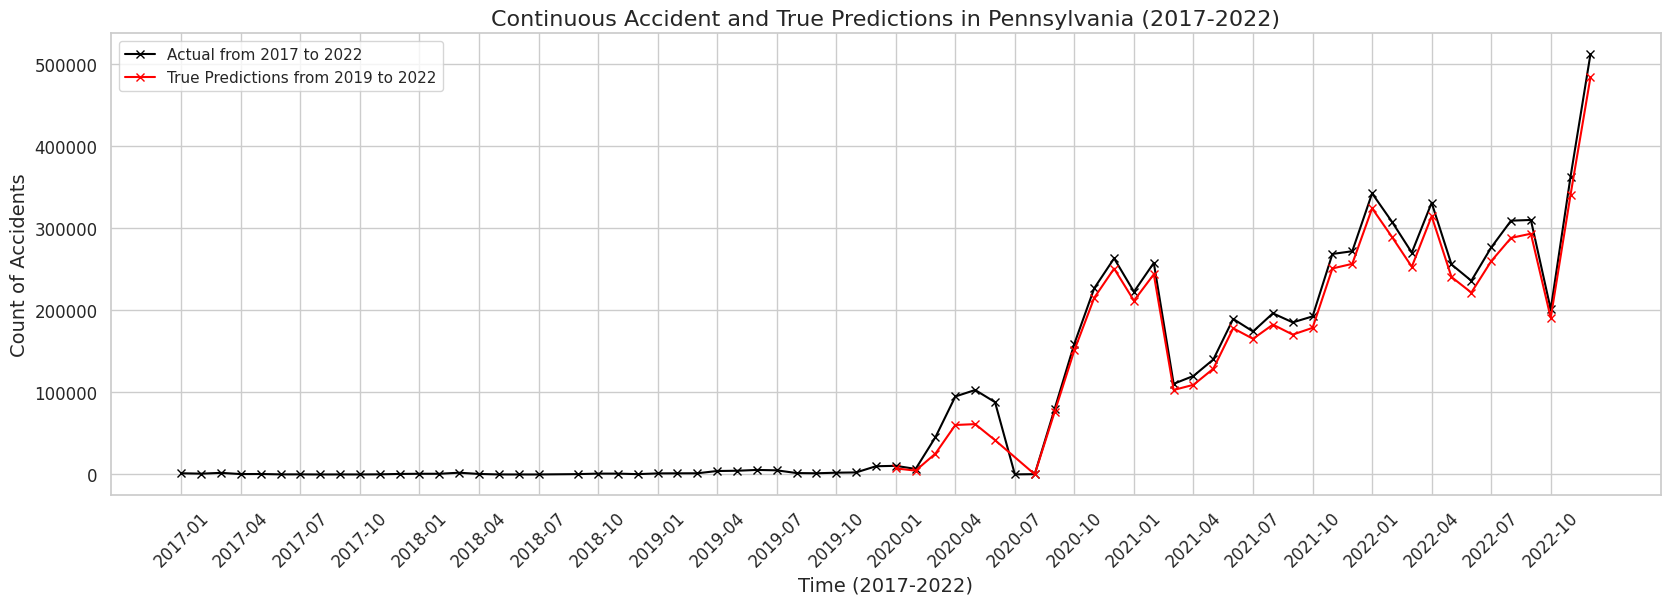

In [4]:
from utility import *

%matplotlib inline

plotter = AccidentPlotter(df_pa, zero_r_predictions)
plotter.plot_accidents()


In [ ]:
plotter.plot_confusion_matrix()